In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("logistics_forecasting_data.csv")

# Display first few rows
print(df.head())  # Verify the first few rows
print(df.columns)  # Check if 'Latitude' and 'Longitude' are correctly loaded

   Shipment_ID  Order_Date  Warehouse_Latitude  Warehouse_Longitude  \
0         2001  2023-01-01           37.490802          -118.742833   
1         2002  2023-01-02           49.014286           -94.543584   
2         2003  2023-01-03           44.639879          -107.425761   
3         2004  2023-01-04           41.973170           -99.657172   
4         2005  2023-01-05           33.120373           -83.697341   

   Destination_Latitude  Destination_Longitude  Shipping_Distance_km  \
0             44.260949            -122.415914                560.46   
1             27.524199             -98.432268               4517.64   
2             29.848861             -97.968244               2551.00   
3             51.956626             -93.128505               4140.96   
4             43.192872             -88.695433               1634.25   

   Shipping_Cost  Fuel_Cost  Labor_Cost  Total_Cost  Delivery_Time_Days  \
0         355.12      37.94      164.45      557.51              

Forecasting and Trend Analysis

(Monthly avg total cost & Trend line)

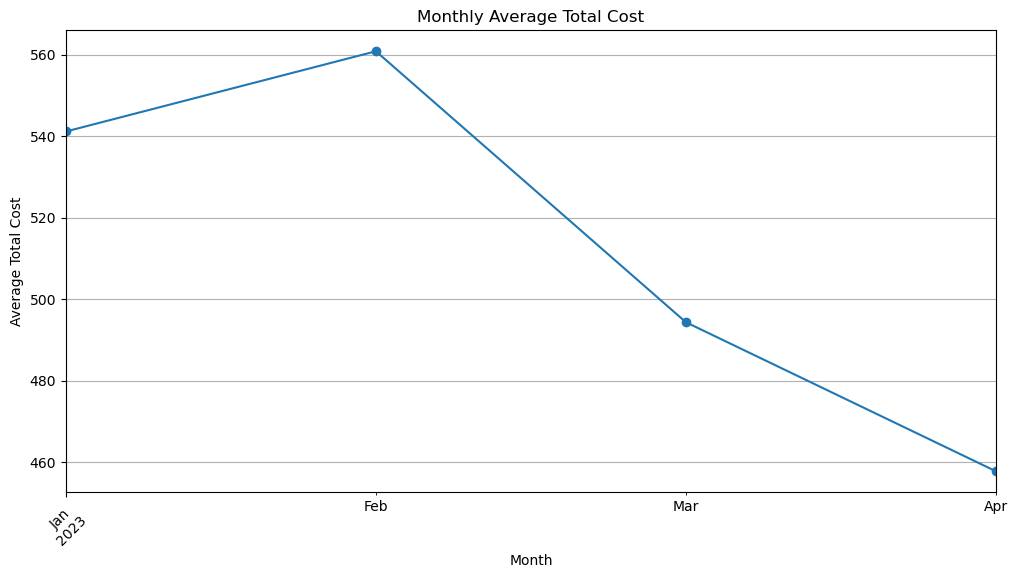

In [2]:
import matplotlib.pyplot as plt

# Convert Order_Date to datetime and extract month
df['Order_Date'] = pd.to_datetime(df['Order_Date'])
df['Month'] = df['Order_Date'].dt.to_period("M")

# Compute monthly average Total_Cost
monthly_avg = df.groupby('Month')['Total_Cost'].mean()

# Plot trend
plt.figure(figsize=(12,6))
monthly_avg.plot(marker='o', linestyle='-')
plt.title("Monthly Average Total Cost")
plt.xlabel("Month")
plt.ylabel("Average Total Cost")
plt.xticks(rotation=45)
plt.grid()
plt.show()


Identify Seasonal Patterns in Shipping Costs

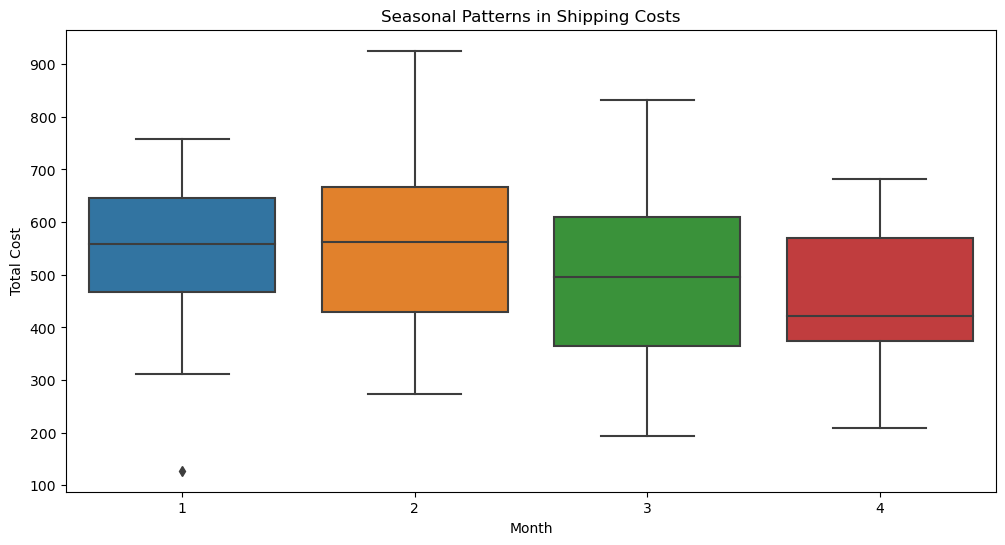

In [3]:
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(x=df['Order_Date'].dt.month, y=df['Total_Cost'])
plt.title("Seasonal Patterns in Shipping Costs")
plt.xlabel("Month")
plt.ylabel("Total Cost")
plt.show()


Simple Moving Average (SMA) for Smoothing

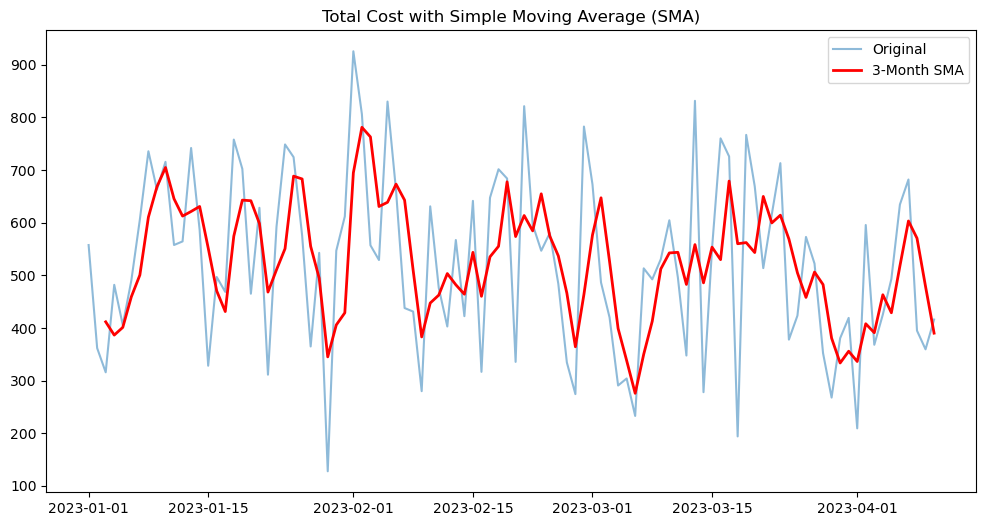

In [4]:
df['SMA_3'] = df['Total_Cost'].rolling(window=3).mean()

# Plot SMA vs. Original Data
plt.figure(figsize=(12,6))
plt.plot(df['Order_Date'], df['Total_Cost'], label="Original", alpha=0.5)
plt.plot(df['Order_Date'], df['SMA_3'], label="3-Month SMA", linewidth=2, color="red")
plt.legend()
plt.title("Total Cost with Simple Moving Average (SMA)")
plt.show()


Predictive Modeling (Linear Regression)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

# Feature selection
features = ['Shipping_Distance_km','Fuel_Cost', 'Labor_Cost']
X = df[features]
y = df['Total_Cost']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R² Score: {r2:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")


R² Score: 0.35
Mean Absolute Error (MAE): 114.88


Warehouse & Delivery Mapping

In [6]:
pip install folium

Note: you may need to restart the kernel to use updated packages.


In [7]:
import folium

df["Weather_Impact"] = pd.to_numeric(df["Weather_Impact"], errors="coerce")

# Sample subset for visualization
subset = df.sample(100)

# Initialize map
m = folium.Map(location=[subset['Warehouse_Latitude'].mean(), subset['Warehouse_Longitude'].mean()], zoom_start=6)

# Add warehouse and delivery locations
for _, row in subset.iterrows():
    folium.CircleMarker(
        location=[row['Destination_Latitude'], row['Destination_Longitude']],
        radius=5,
        color='red' if row['Weather_Impact'] > 1 else 'blue',
        fill=True
    ).add_to(m)

m


Route Efficiency: Haversine Distance vs. Shipping Distance

In [8]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


C:\Users\jonbe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


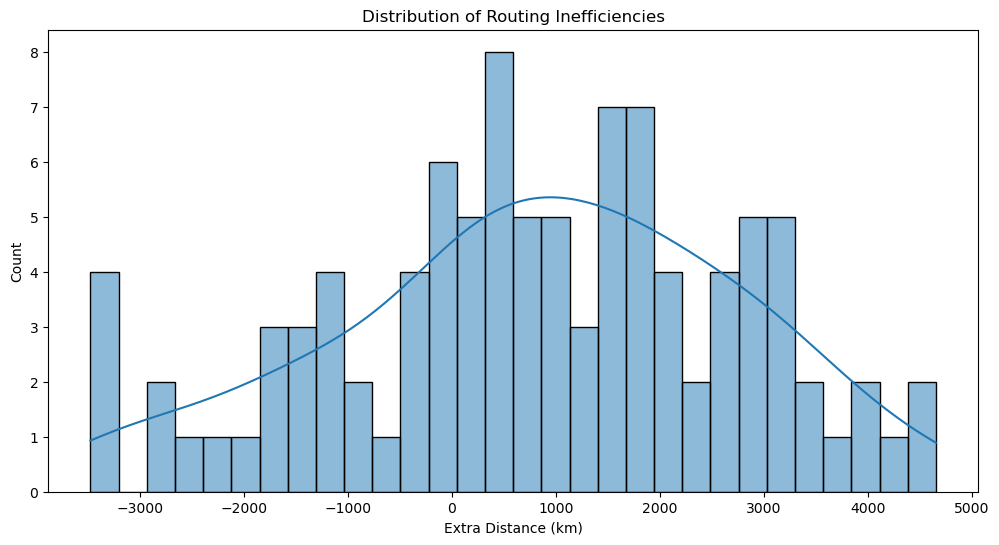

In [9]:
from geopy.distance import geodesic

# Function to calculate Haversine distance
def haversine_distance(row):
    return geodesic((row['Warehouse_Latitude'], row['Warehouse_Longitude']), (row['Destination_Latitude'], row['Destination_Longitude'])).km

# Compute and compare
df['Haversine_Distance_km'] = df.apply(haversine_distance, axis=1)
df['Efficiency_Loss_km'] = df['Shipping_Distance_km'] - df['Haversine_Distance_km']

# Plot inefficiency distribution
plt.figure(figsize=(12,6))
sns.histplot(df['Efficiency_Loss_km'], bins=30, kde=True)
plt.title("Distribution of Routing Inefficiencies")
plt.xlabel("Extra Distance (km)")
plt.show()


Outlier Detection in Shipping Cost

Number of Outliers: 0


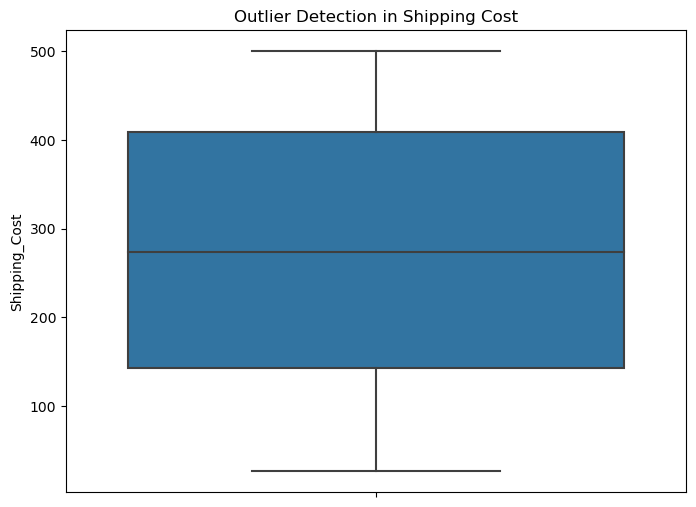

In [16]:
# IQR method for outlier detection
Q1 = df['Shipping_Cost'].quantile(0.25)
Q3 = df['Shipping_Cost'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['Shipping_Cost'] < lower_bound) | (df['Shipping_Cost'] > upper_bound)]
print("Number of Outliers:", len(outliers))

# Box plot
plt.figure(figsize=(8,6))
sns.boxplot(y=df['Shipping_Cost'])
plt.title("Outlier Detection in Shipping Cost")
plt.show()


Python Script for Anomaly Alerts

In [14]:
import smtplib
from email.message import EmailMessage

# Function to send email alert for lost shipments
def send_alert(email_recipient, lost_shipments):
    if lost_shipments.empty:
        return "No lost shipments detected."
    
    message = EmailMessage()
    message.set_content(f"ALERT: {len(lost_shipments)} shipments marked as LOST!")
    message['Subject'] = "🚨 Lost Shipment Alert 🚨"
    message['From'] = "jonbegeny@gmail.com"
    message['To'] = email_recipient

    # Send email (Mocked)
    print("Email alert sent to:", email_recipient)

# Detect lost shipments
lost_shipments = df[df['Shipment_Anomaly'].astype(str).str.lower() == 'lost']

# Send alert
send_alert("jonbegeny@gmail.com", lost_shipments)


Email alert sent to: jonbegeny@gmail.com


SQL Stored Procedure for Cost Anomalies

In [15]:
import sqlite3
import pandas as pd

# Step 1: Load the CSV file into a pandas DataFrame
df = pd.read_csv('logistics_forecasting_data.csv')

# Step 2: Create an SQLite connection
conn = sqlite3.connect('logistics.db')  # SQLite database in a file

# Step 3: Convert the DataFrame into an SQLite table (if not exists)
df.to_sql('shipments', conn, if_exists='replace', index=False)

# Step 4: Add the 'Anomaly_Flag' column if it doesn't exist
try:
    conn.execute("""
        ALTER TABLE shipments
        ADD COLUMN Anomaly_Flag TEXT
    """)
except sqlite3.OperationalError:
    # This error is raised if the column already exists, we can safely ignore it
    print("Anomaly_Flag column already exists.")

# Step 5: Calculate the median using Python
median_cost = df['Total_Cost'].median()

# Step 6: Calculate the threshold for high-cost shipments (3 times the median)
high_cost_threshold = 1.1 * median_cost

# Step 7: Flag the shipments in the DataFrame where Total_Cost is greater than the threshold
df['Anomaly_Flag'] = df['Total_Cost'].apply(lambda x: 'High Cost' if x > high_cost_threshold else None)

# Step 8: Update the SQLite database with the new Anomaly_Flag values
for _, row in df.iterrows():
    conn.execute("""
        UPDATE shipments
        SET Anomaly_Flag = ?
        WHERE Shipment_ID = ?
    """, (row['Anomaly_Flag'], row['Shipment_ID']))

# Step 9: Commit the changes
conn.commit()

# Step 10: Retrieve the updated data to check for the changes
updated_df = pd.read_sql_query("SELECT Shipment_ID, Total_Cost, Anomaly_Flag FROM shipments", conn)

# Step 11: Display the updated data (optional)
print(updated_df)

# Step 12: Close the SQLite connection
conn.close()


    Shipment_ID  Total_Cost Anomaly_Flag
0          2001      557.51         None
1          2002      361.69         None
2          2003      315.71         None
3          2004      481.90         None
4          2005      405.57         None
..          ...         ...          ...
95         2096      634.49    High Cost
96         2097      682.02    High Cost
97         2098      394.94         None
98         2099      359.43         None
99         2100      415.96         None

[100 rows x 3 columns]
